# After training analysis
Create table and plots; reuse code from `mlp-classifier-experiments
`

In [63]:
import pickle

import string
import editdistance

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [116]:
sns.set_theme()
sns.set_context('paper', font_scale=1.4)
plt.style.use('ggplot')
pd.set_option('precision', 4)

In [65]:
punctuations = set(string.punctuation)
stopwords = set(nltk.corpus.stopwords.words('english'))
ps = nltk.PorterStemmer()

In [66]:
def load_file(path, skip_id=False, has_label=True):
    """
    has_label: also return label column if True
    return [['hello world', 'hi'], ['hi World', 'hello']]
    """
    first_lines = []
    second_lines = []
    if has_label:
        labels = []
    if skip_id:
        start_col_idx = 1
    else:
        start_col_idx = 0
    with open(path, 'rt') as f:
        for line in f:
            chunks = line.strip().split('\t')
            first = chunks[start_col_idx]
            second = chunks[start_col_idx + 1]
            first_lines.append(first)
            second_lines.append(second)
            
            if has_label:
                label = int(chunks[start_col_idx + 2])
                labels.append(label)
    if has_label:
        ret = pd.DataFrame({
            'line1': first_lines, 
            'line2': second_lines, 
            'is_paraphrase': labels
        })
    else:
        ret = pd.DataFrame({
            'line1': first_lines, 
            'line2': second_lines
        })
    return ret

In [67]:
def clean_text(text, remove_punkt=False, remove_stopwords=False, stem=False):
    tokens = word_tokenize(text.lower())
    if remove_punkt:
        tokens = [tok for tok in tokens if not tok in punctuations]
    if remove_stopwords:
        tokens = [tok for tok in tokens if not tok in stopwords]
    if stem:
        tokens = [ps.stem(tok) for tok in tokens]
    return tokens

In [68]:
def construct_features(first_lines, second_lines):
    # number of unique overlapping unigrams, edit distance
    features = np.empty((len(first_lines), 2))
    for idx, tup in enumerate(zip(first_lines, second_lines)):
        first, second = tup
        num_unigrams = len(set(first).intersection(second))
        edit_dist = editdistance.eval(first, second)
        features[idx, 0] = num_unigrams
        features[idx, 1] = edit_dist
    return features

In [4]:
dev = load_file('data/dev+devtest/dev.tsv')
devtest = load_file('data/dev+devtest/devtest.tsv')
test = load_file('data/test_no_labels.tsv', skip_id=True, has_label=False)
dev_hard = load_file('data/heldout-hard/dev.hard.tsv')
devtest_hard = load_file('data/heldout-hard/devtest.hard.tsv')
test_hard = load_file('data/heldout-hard/test.hard.tsv', has_label=False)

In [147]:
normal = pd.concat([dev, devtest])
hard = pd.concat([dev_hard, devtest_hard])
dev_big, devtest_small = train_test_split(normal, random_state=0)
dev_hard_big, devtest_hard_small = train_test_split(hard, random_state=0)

In [148]:
len(dev), len(devtest), len(test), len(dev_hard), len(devtest_hard), len(test_hard)

(818, 805, 3000, 1000, 1000, 3000)

In [145]:
len(dev_big), len(devtest_small), len(dev_hard_big), len(devtest_hard_small)

(1217, 406, 1500, 500)

In [5]:
with open('output/mlp-experiments.pkl', 'rb') as f:
    experiments = pickle.load(f)

In [6]:
results = pd.read_csv('output/mlp-results.csv')

# Accuracy tables and plots

In [34]:
results.sort_values(by=['dataset', 'train_accu', 'val_accu'],
                    ascending=[False, True, True],
                    inplace=True)

In [40]:
results.head()

,config,dataset,train_accu,val_accu
6,combined,normal,0.6901,0.6678
7,combined_normal,normal,0.6901,0.8128
11,no_punkt_stopwords,normal,0.7757,0.8128
14,no_punkt_stopwords_stem,normal,0.7946,0.8177
9,no_punkt,normal,0.8233,0.8522


In [31]:
df = results.melt(id_vars=['config', 'dataset'], 
                  value_vars=['train_accu', 'val_accu'])

In [30]:
df.head()

,config,dataset,variable,value
0,baseline,normal,train_accu,0.841076
1,baseline_hard,hard,train_accu,0.725000
2,tokenized,normal,train_accu,0.844743
3,tokenized_hard,hard,train_accu,0.689000
4,big,normal,train_accu,0.842235


<AxesSubplot:xlabel='variable', ylabel='value'>

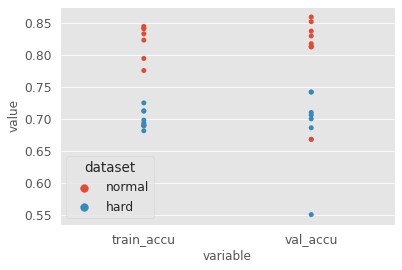

In [117]:
sns.stripplot(data=df, x='variable', y='value', hue='dataset', jitter=False)

# Text cleaning on example sentences

In [105]:
drop_idx = []
for _ in range(20):
    idx = devtest_hard.drop(drop_idx).line1.apply(len).idxmin()
    drop_idx.append(idx)
line1 = devtest_hard.line1[idx]
print(line1)
print(clean_text(line1))
print(clean_text(line1, remove_punkt=True))
print(clean_text(line1, remove_stopwords=True))
print(clean_text(line1, stem=True), end='\n\n')
line2 = devtest_hard.line2[idx]
print(line2)
print(clean_text(line2))
print(clean_text(line2, remove_punkt=True))
print(clean_text(line2, remove_stopwords=True))
print(clean_text(line2, stem=True))

Steam can also be used , and does not need to be pumped .
['steam', 'can', 'also', 'be', 'used', ',', 'and', 'does', 'not', 'need', 'to', 'be', 'pumped', '.']
['steam', 'can', 'also', 'be', 'used', 'and', 'does', 'not', 'need', 'to', 'be', 'pumped']
['steam', 'also', 'used', ',', 'need', 'pumped', '.']
['steam', 'can', 'also', 'be', 'use', ',', 'and', 'doe', 'not', 'need', 'to', 'be', 'pump', '.']

Steam can also be pumped and need not be used .
['steam', 'can', 'also', 'be', 'pumped', 'and', 'need', 'not', 'be', 'used', '.']
['steam', 'can', 'also', 'be', 'pumped', 'and', 'need', 'not', 'be', 'used']
['steam', 'also', 'pumped', 'need', 'used', '.']
['steam', 'can', 'also', 'be', 'pump', 'and', 'need', 'not', 'be', 'use', '.']


In [108]:
devtest_hard.is_paraphrase[idx]

0

In [107]:
print(editdistance.eval(clean_text(line1), clean_text(line2)))
print(editdistance.eval(
    clean_text(line1, remove_punkt=True),
    clean_text(line2, remove_punkt=True)
))
print(editdistance.eval(
    clean_text(line1, remove_stopwords=True),
    clean_text(line2, remove_stopwords=True)
))
print(editdistance.eval(
    clean_text(line1, stem=True),
    clean_text(line2, stem=True)
))

6
5
3
6


# Feature visualization

In [122]:
X = construct_features(dev.line1.apply(clean_text), 
                       dev.line2.apply(clean_text))
dev_df = pd.DataFrame({
    'unigrams': X[:, 0],
    'edit_dist': X[:, 1],
    'labels': dev.is_paraphrase
})

In [218]:
X = construct_features(dev_hard.line1.apply(clean_text), 
                       dev_hard.line2.apply(clean_text))
dev_hard_df = pd.DataFrame({
    'unigrams': X[:, 0],
    'edit_dist': X[:, 1],
    'labels': dev_hard.is_paraphrase
})

In [219]:
kws = {'remove_punkt': True, 'remove_stopwords': True, 'stem': True}
X = construct_features(dev_hard.line1.apply(clean_text, **kws), 
                       dev_hard.line2.apply(clean_text, **kws))
dev_hard_best_df = pd.DataFrame({
    'unigrams': X[:, 0],
    'edit_dist': X[:, 1],
    'labels': dev_hard.is_paraphrase
})

In [220]:
display(dev_df.corr())
display(dev_hard_df.corr())
display(dev_hard_best_df.corr())

,unigrams,edit_dist,labels
unigrams,1.0000,0.2877,0.4417
edit_dist,0.2877,1.0000,-0.2765
labels,0.4417,-0.2765,1.0000


,unigrams,edit_dist,labels
unigrams,1.0000,0.2335,-0.0429
edit_dist,0.2335,1.0000,-0.2896
labels,-0.0429,-0.2896,1.0000


,unigrams,edit_dist,labels
unigrams,1.0000,0.2471,-0.0343
edit_dist,0.2471,1.0000,-0.4299
labels,-0.0343,-0.4299,1.0000


In [222]:
display(dev_df.cov())
display(dev_hard_df.cov())
display(dev_hard_best_df.cov())

,unigrams,edit_dist,labels
unigrams,14.4172,5.3700,0.8094
edit_dist,5.3700,24.1706,-0.6559
labels,0.8094,-0.6559,0.2329


,unigrams,edit_dist,labels
unigrams,15.3518,3.6631,-0.0833
edit_dist,3.6631,16.0350,-0.5749
labels,-0.0833,-0.5749,0.2458


,unigrams,edit_dist,labels
unigrams,8.1950,1.8566,-0.0487
edit_dist,1.8566,6.8896,-0.5594
labels,-0.0487,-0.5594,0.2458


In [221]:
print(dev_df.corr().to_latex())
print(dev_hard_df.corr().to_latex())
print(dev_hard_best_df.corr().to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  unigrams &  edit\_dist &  labels \\
\midrule
unigrams  &    1.0000 &     0.2877 &  0.4417 \\
edit\_dist &    0.2877 &     1.0000 & -0.2765 \\
labels    &    0.4417 &    -0.2765 &  1.0000 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
{} &  unigrams &  edit\_dist &  labels \\
\midrule
unigrams  &    1.0000 &     0.2335 & -0.0429 \\
edit\_dist &    0.2335 &     1.0000 & -0.2896 \\
labels    &   -0.0429 &    -0.2896 &  1.0000 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
{} &  unigrams &  edit\_dist &  labels \\
\midrule
unigrams  &    1.0000 &     0.2471 & -0.0343 \\
edit\_dist &    0.2471 &     1.0000 & -0.4299 \\
labels    &   -0.0343 &    -0.4299 &  1.0000 \\
\bottomrule
\end{tabular}



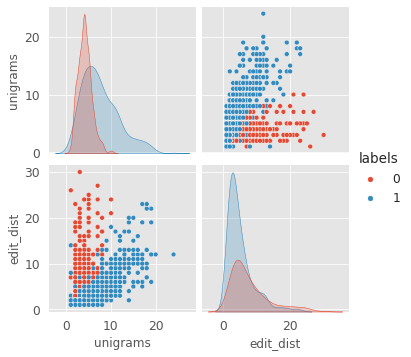

In [129]:
sns.pairplot(data=dev_df, hue='labels')

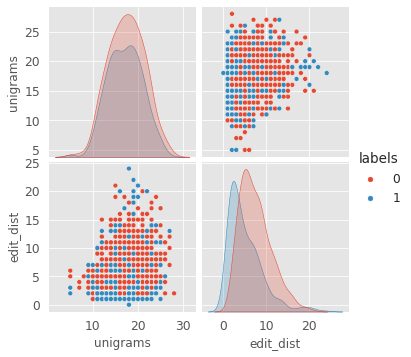

In [130]:
sns.pairplot(data=dev_hard_df, hue='labels')

<AxesSubplot:>

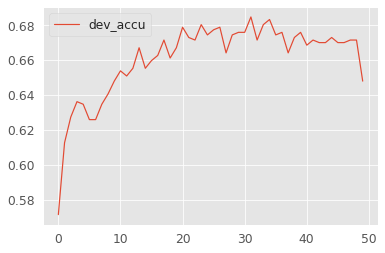

In [119]:
rnn_df = pd.read_csv('output/rnn_training.csv')
rnn_df.dev_accu.plot(legend=True)

# Error Analysis

Text(28.700000000000003, 0.5, 'True labels')

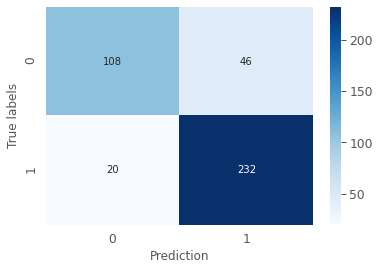

In [214]:
model = experiments['big']['model']
kws = {}
X = construct_features(devtest_small.line1.apply(clean_text, **kws), 
                       devtest_small.line2.apply(clean_text, **kws))
y_pred = model.predict(X)
mask_big = (devtest_small.is_paraphrase != y_pred)
conf_mat = confusion_matrix(devtest_small.is_paraphrase, y_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Prediction')
ax.set_ylabel('True labels')

In [194]:
model = experiments['no_punkt']['model']
kws = {'remove_punkt': True}
X = construct_features(devtest_small.line1.apply(clean_text, **kws), 
                       devtest_small.line2.apply(clean_text, **kws))
y_pred = model.predict(X)
mask_no_punkt = (devtest_small.is_paraphrase != y_pred)

In [195]:
err_big = devtest_small[mask_big]
err_no_punkt = devtest_small[mask_no_punkt]
len(err_big), len(err_no_punkt)

(66, 60)

In [196]:
# errors that the big model made but punkt didn't make
err_big[~err_big.index.isin(err_no_punkt.index)]

,line1,line2,is_paraphrase
702,I ain't sleeping tonight.,I'm sleeping.,0
393,Garcia checkedwith the state police.,to the state.,0
370,You got your name in the paper,you have your name on paper.,1
770,Hurry up! - Hang on!,hurry up!,1
46,"Some are useful, some aren't.","some are sick, some hurt.",0
220,"Bitch, move over.","come on, bitch.",1
204,"She's in a play, and I promised dorothy I woul...","she promised she would do it, and I kept remin...",0
291,That sounded a little desperate.,that sounded weird.,0
169,(c) the amounts concerned are small.,(e) the rapporteur concerned / concerned.,0
525,"The big red button turned it on, therefore... ...",turn on the big red button...... and then........,1


In [197]:
# errors that punkt made but big didn't make
err_no_punkt[~err_no_punkt.index.isin(err_big.index)]

,line1,line2,is_paraphrase
561,"Hey, kid, you wanna hear a joke?",you wanna hear the truth?,0
708,"I'm telling the truth, Doc.",I'm telling you.,0
19,I didn't do anything more than that to you or ...,I don't want to be connected to you any more t...,0
9,"And I'm fucked here, man.",and I'm fucked!,0
402,"So, what brings you to town?",what brings you here?,0
115,"And I'm fucked here, man.",I'm fucked!,0
196,"These are my friends, Mom.","they're friends, Mom.",1
211,"No, I tried that.",I tried!,0
597,Too damn late for this bullshit!,too late for that,0


Text(28.700000000000003, 0.5, 'True labels')

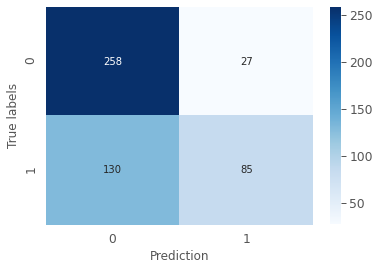

In [215]:
model = experiments['big_hard']['model']
kws = {}
X = construct_features(devtest_hard_small.line1.apply(clean_text, **kws), 
                       devtest_hard_small.line2.apply(clean_text, **kws))
y_pred = model.predict(X)
mask_big = (devtest_hard_small.is_paraphrase != y_pred)
conf_mat = confusion_matrix(devtest_hard_small.is_paraphrase, y_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Prediction')
ax.set_ylabel('True labels')

Text(28.700000000000003, 0.5, 'True labels')

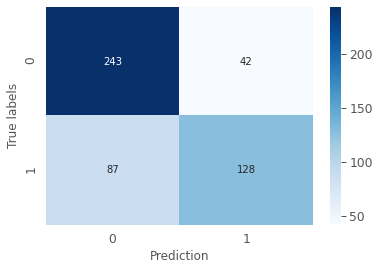

In [216]:
model = experiments['no_punkt_stopwords_stem_hard']['model']
kws = {'remove_punkt': True, 'remove_stopwords': True, 'stem': True}
X = construct_features(devtest_hard_small.line1.apply(clean_text, **kws), 
                       devtest_hard_small.line2.apply(clean_text, **kws))
y_pred = model.predict(X)
mask_no_punkt = (devtest_hard_small.is_paraphrase != y_pred)
conf_mat = confusion_matrix(devtest_hard_small.is_paraphrase, y_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Prediction')
ax.set_ylabel('True labels')

In [211]:
err_big = devtest_hard_small[mask_big]
err_no_punkt = devtest_hard_small[mask_no_punkt]
len(err_big), len(err_no_punkt)

(157, 129)

In [212]:
# errors that the big model made but punkt didn't make
err_big[~err_big.index.isin(err_no_punkt.index)]

,line1,line2,is_paraphrase
190,"After his service , Lockhart lived in Florida ...",After his service Lockhart lived in Florida bu...,1
249,Julio Junqueira was the first to be built in A...,Dr. Julio Junqueira was the first to be built ...,1
191,"That I lost , That I left .",That I have lost that I left .,1
205,65 soldiers have been killed during the missio...,"During the mission , 65 soldiers were killed :...",1
905,"He was equally successful at the admiralty , b...","He was equally successful with the admiralty ,...",1
27,In 2014 Jackie appeared as a guest commenting ...,In 2014 Jackie has appeared as a guest on 107....,1
918,Abu Halifa or Abu Hulayfah or Abu Huleifa or A...,Abu Halifa or Abu Hulayfah or Abu Huleifa or A...,1
107,"According to the United States Census Bureau ,...","According to the United States Census Bureau ,...",1
260,The number of reported fires in early February...,The number of reported fires at the beginning ...,1
37,He designates this a new discovery of fiction ...,He describes this as a new discovery of fictio...,1


In [213]:
# errors that punkt made but big didn't make
err_no_punkt[~err_no_punkt.index.isin(err_big.index)]

,line1,line2,is_paraphrase
754,Three brigades ( 11 Battalions ) were raised f...,Three brigades ( 11 battalions ) were trained ...,0
15,"She was the mother of Val , Boris and Rosalind...","She became mother of Val , Boris and Rosalind ...",0
276,"In 1972 , the New Ways to Work Foundation was ...","In 1972 , the New Ways to Work Foundation was ...",0
977,The latest track `` Every Morning '' is the ac...,"The first track , `` Every Morning '' is the a...",0
600,Lobethal Bierhaus is a regional brewery with G...,Lobethal Bierhaus is a German brewery with reg...,0
110,After brief fighting Hari Singh Nalwa forced S...,"After brief fighting , Hari Singh forced Nalwa...",0
522,The Olt River is a tributary of the Seghes Riv...,The Olt River is a tributary of the River Segh...,1
899,Cabo Cassiporé is a wide promontory to the eas...,Cabo Cassiporé is a wide promontory about east...,0
814,"In the history of such devices , it preceded `...",In the history of such devices '' The Turk `` ...,0
955,While discussing the matter should go to his d...,While discussing the matter should go over to ...,0
